In [47]:
import pandas as pd
from numpy.random import normal, binomial, seed
import random
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

seed(42)
random.seed(42)  # set seed for reproducibility

In [48]:
columns = ["case_id", "activity", "event_order", "exchange_rate"]
event_logs = pd.DataFrame(columns=columns)

In [49]:
def generate_activity(case_id: int, name: str, event_order=1) -> pd.DataFrame:
    """
    Generates an event log for the "Check-in"-activity.
    """
    return pd.DataFrame(
        {
            "case_id": [case_id],
            "activity": [name],
            "event_order": [event_order],
            "exchange_rate": [None],
        }
    )


print("example row: \n", generate_activity(1, "Check-in"))  # check whether it works
print("\n--------------------------------------------\n")
print("example row: \n", generate_activity(1, "Pays", 3))  # check whether it works
print("\n--------------------------------------------\n")


def generate_exchange_rate(case_id: int, event_order: int) -> pd.DataFrame:
    """
    Generates an event log for the "Check exchange rate"-activity.
    Retrieved exchange rates are sampled from normal distribution w/ mean 1 std 0.1
    """
    rate = round(normal(1, 0.1), 2)
    return pd.DataFrame(
        {
            "case_id": [case_id],
            "activity": ["Check exchange rate"],
            "event_order": [event_order],
            "exchange_rate": [rate],
        }
    )


print(
    "example row for Check exchange rate: \n", generate_exchange_rate(1, 3)
)  # check whether it works
print("\n--------------------------------------------\n")

example row: 
    case_id  activity  event_order exchange_rate
0        1  Check-in            1          None

--------------------------------------------

example row: 
    case_id activity  event_order exchange_rate
0        1     Pays            3          None

--------------------------------------------

example row for Check exchange rate: 
    case_id             activity  event_order  exchange_rate
0        1  Check exchange rate            3           1.05

--------------------------------------------



In [50]:
def generate_case(case_id: int, is_final=True) -> pd.DataFrame:
    """
    this function combines the different generators from above to create an artifical process instance.
    """
    event_order = 1
    case = generate_activity(case_id, "Check-in", event_order)
    event_order += 1
    ##### removed this block as algorithm cannot handle non-timeseries samples
    # # randomly decide whether guest has enough cash
    # if random.uniform(0, 1) > 0.9:
    #     payment = generate_activity(case_id, "Pays", event_order)
    #     case = pd.concat([case, payment])
    #     return case

    exchange_rate = generate_exchange_rate(case_id, 2)
    case = pd.concat([case, exchange_rate])
    event_order += 1

    for i in range(0, 10):
        exchange_rate = generate_exchange_rate(case_id, event_order)
        case = pd.concat([case, exchange_rate])
        event_order += 1

    if is_final:
        # idea:
        # sample from binomial distribution in a way, so that higher exchange rates increase the success probability
        # to achieve this, set success probabilty of binomial distribution to last exchange rate - mean(exchange rate) + 0.5
        success_probability = 1 if exchange_rate.loc[0, "exchange_rate"] > 1 else 0
    else:
        success = (
            True
            if case[case["activity"] == "Check exchange rate"]["exchange_rate"].mean()
            > 1
            else False
        )
        success_probability = 0.9 if success else 0

    does_exchange = binomial(1, success_probability)
    # if the guest does exchange, add the follow-up activities and end the process.
    # else continue
    if does_exchange:
        result = generate_activity(case_id, "Pays cash", event_order)
    else:
        result = generate_activity(case_id, "Pays by card", event_order)
    event_order += 1

    return pd.concat([case, result])


print("example process instance: \n", generate_case(1))

example process instance: 
    case_id             activity  event_order exchange_rate
0        1             Check-in            1          None
0        1  Check exchange rate            2          0.99
0        1  Check exchange rate            3          1.06
0        1  Check exchange rate            4          1.15
0        1  Check exchange rate            5          0.98
0        1  Check exchange rate            6          0.98
0        1  Check exchange rate            7          1.16
0        1  Check exchange rate            8          1.08
0        1  Check exchange rate            9          0.95
0        1  Check exchange rate           10          1.05
0        1  Check exchange rate           11          0.95
0        1  Check exchange rate           12          0.95
0        1         Pays by card           13          None


In [51]:
# check whether our data generation works in principle

data = pd.DataFrame()
for case_id in range(1, 100):
    data = pd.concat([data, generate_case(case_id)])

print("Number of generated rows: ", len(data))
display(data.head(5))
display(data.tail(5))

Number of generated rows:  1287


,case_id,activity,event_order,exchange_rate
0,1,Check-in,1,None
0,1,Check exchange rate,2,0.74
0,1,Check exchange rate,3,1.10
0,1,Check exchange rate,4,1.08
0,1,Check exchange rate,5,0.85


,case_id,activity,event_order,exchange_rate
0,99,Check exchange rate,9,1.04
0,99,Check exchange rate,10,0.97
0,99,Check exchange rate,11,1.04
0,99,Check exchange rate,12,1.05
0,99,Pays cash,13,None


In [52]:
# generate the whole dataset (takes a bit longer)

data = pd.DataFrame()

for case_id in range(1, 10000):
    data = pd.concat([data, generate_case(case_id)])

data.to_csv("edt-ts/data/group5_checkin.csv", index=False)

In [53]:
# generate the whole random dataset (takes a bit longer)

data = pd.DataFrame()

for case_id in range(1, 10000):
    data = pd.concat([data, generate_case(case_id, is_final=False)])

data.to_csv("edt-ts/data/group5_checkin_random.csv", index=False)

In [54]:
print(
    "Number of instances where guest payed immediately: ",
    len(data[(data["activity"] == "Pays") & (data["event_order"] == 2)]),
)
print(
    "Number of instances where guest had to exchange money: ",
    len(data[(data["activity"] == "Check exchange rate") & (data["event_order"] == 2)]),
)

Number of instances where guest payed immediately:  0
Number of instances where guest had to exchange money:  9999


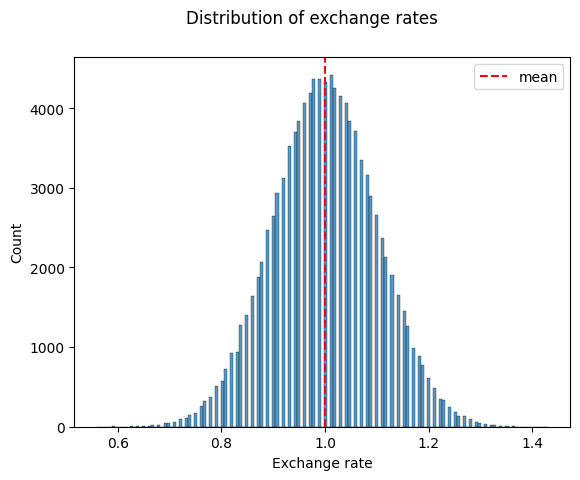

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(data[data["activity"] == "Check exchange rate"]["exchange_rate"])
plt.axvline(
    data[data["activity"] == "Check exchange rate"]["exchange_rate"].mean(),
    linestyle="--",
    c="red",
    label="mean",
)
plt.legend()
plt.suptitle("Distribution of exchange rates ")
plt.xlabel("Exchange rate")
plt.show()